In [1]:
# Used libraries

import csv
import re
from brian2 import *
import numpy as np
from scipy.interpolate import interp1d
import brian2.numpy_ as np
import matplotlib.pyplot as plt
import time
import warnings
from scipy import interpolate


# ML eNeuron (electronic Neuron)

Visualising the transfer function (firing rate depending on input current) and membrane potential shape (potential depending on time) of the ML eNeuron from post layout simulation results.



number of point =  10091 , a magnitude of input current of : 10.03 nA


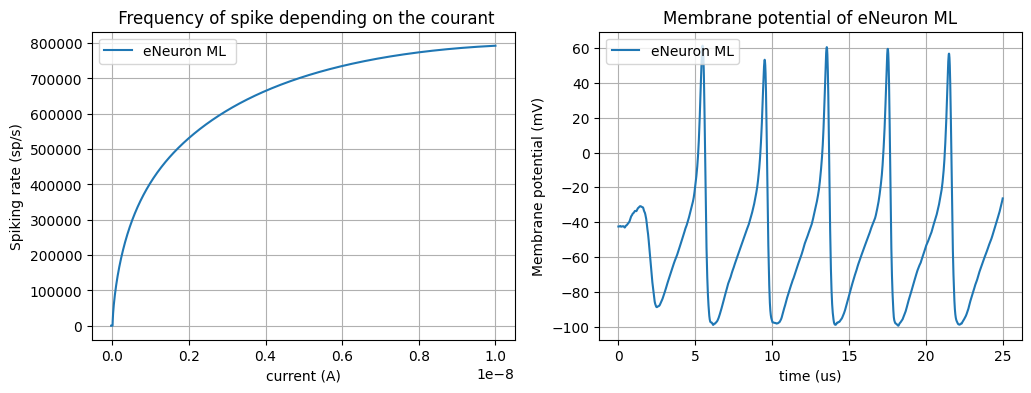

In [2]:
# Importing the .csv file of firing rate depending on the input current from PSL results
csv_file_path = 'FT_augmented.csv' #Activation function 
input_current = []
spike_rate = []

# Open the CSV file
with open(csv_file_path, 'r') as file:
    csv_reader = csv.reader(file, delimiter='\t')
    # Skip the header row
    next(csv_reader)
    for row in csv_reader:
        values = re.split(r',', row[0])
        input_current.append(float(values[0]))
        spike_rate.append(float(values[1]))
        
print("number of point = ", len(spike_rate), ", a magnitude of input current of :", (max(input_current)-min(input_current))*1e9,"nA")


csv_file_path = 'spike.csv'

time = []
v_spike = []

with open(csv_file_path, 'r') as file:
    csv_reader = csv.reader(file, delimiter='\t')
    next(csv_reader)
    for row in csv_reader:
        values = re.split(r'\s+', row[0])

        time.append(float(values[0])*1e6)
        v_spike.append(float(values[1])*1e3) 


# Plot the data
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)  
plt.plot(input_current, spike_rate, label='eNeuron ML ')
plt.xlabel('current (A)')
plt.ylabel('Spiking rate (sp/s)')
plt.title(' Frequency of spike depending on the courant')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)  
plt.plot(time[:2500], v_spike[:2500], label='eNeuron ML')
plt.xlabel('time (us)')
plt.ylabel('Membrane potential (mV)')
plt.title('Membrane potential of eNeuron ML')
plt.grid(True)
plt.legend()

plt.show()

In [3]:
def reducing_list(original_list, new_size):
    '''
        Function that reduces the size of a list and lessen the amount of computation
    In input:
        - Original_list: list you want to reduce in size
        - new_size: size desired for the list
    It returns:
        - Similar list with desired size
    '''
    original_size = len(original_list)
    if new_size >= original_size:
        return original_list  

    # Calculate the sampling interval
    interval = original_size / new_size

    # Sample elements at regular intervals
    new_list = [original_list[int(i * interval)] for i in range(new_size)]

    return new_list



x = input_current
y = spike_rate

nb_point_interpolation = 1101

funct = interpolate.interp1d(x, y)

x_reduit = reducing_list(x,nb_point_interpolation)
y_reduit = reducing_list(y,nb_point_interpolation)

x_fit = np.linspace(min(x), max(x),min(nb_point_interpolation,len(spike_rate)))
y_fit = funct(x_reduit)   



In [4]:
# Force Brian to use numpy for code generation
prefs.codegen.target = 'numpy'

# Here I reduced the size of the data to accelerate the next processus
i_new = reducing_list(input_current,nb_point_interpolation)
f_new = reducing_list(spike_rate,nb_point_interpolation)

# Convert data to use with Brian2
i_new = i_new * amp  # Now x2 is in amperes
f_new = f_new * Hz      # Now y2 is in amperes (ensure this is the correct unit!)

interp_function = interp1d(i_new, f_new, fill_value='extrapolate')

@check_units(x=amp, result = Hz)
def y_interp_function(x):
    return interp_function(x)*Hz

# Modeling the ML eNeuron with Brian2 equations

### Name: Analog Spiking Neuron Model for Unsupervised STDP-based learning in Neuromorphic Circuits

    => equations described in the paper



### WITHOUT leaky term

In [5]:
from brian2 import clear_cache
from brian2 import device
device.reinit()
start_scope()

# Simulation parameters
defaultclock.dt = 0.01*us  

min_input_current, max_input_current = min(i_new), max(i_new)
v_rest = -80*mV
v_threshold = 60*mV  
v_reset = -100*mV
refrac = 0*us
v0 = -40*mV  
tau = 0.5*ms
tau2 = 15*us
Rm = 5000*Mohm
I0=1*amp
a_v = 1126.6343973469338
b_v = 169200.45773494235
alpha_e = 0.15
alpha_i = 0.04
beta_e = 1.9
beta_i = 0.5
x_threshold_v= 8.3e-11*amp
avoid_error = 0.01*pA #This constant exists only to make sure that there isn't in any case a log(0) which implies errors.
a_value = 6.23667974e13
k_redres = 0.007704519252680564
k_redres = -0.00930049450970849
k_redres = -0.0018141002616710589

avoid_error = 0.01*pA
c = 1


# 1-segment model
neuron_eqs_v1 = '''
dv/dt = 0*(v_rest - v) / tau2 + redress*((y_interp_function(I_total)*I0/(a_value*Hz))*Rm)/ tau : volt (unless refractory)
I_total = clip(Ie + I_inhi + I, 0*nA, 12*nA) : amp
Ie =  alpha_e*ge * uS *(80*mV -c*v)           : amp
I_inhi =  alpha_i*gi * uS *(-120*mV -c*v)           : amp
I : amp
redress = 1+ k_redres*I_total/max_input_current     : 1
dge/dt = -ge/(beta_e*us)            : 1
dgi/dt = -gi/(beta_i*us)            : 1
'''

# 2-segment model
V_a, V_b= 70*mV,90*mV
R_a = Rm*(V_a/mV)/(5/6)/(abs(v_threshold/mV)+abs(v_reset/mV))  #New resistance for rising till V_a
R_b = Rm*(V_b/mV)/(1/6)/(abs(v_threshold/mV)+abs(v_reset/mV)) #New resistance for rising till V_b
neuron_eqs_v2 = '''
dv/dt = 0*(v_rest - v) / tau2 + redress*((y_interp_function(I_total)*I0/(a_value*Hz))*Rm)/ tau : volt (unless refractory)
I_total = clip(Ie + I_inhi + I, 0*nA, 12*nA) : amp
Ie =  alpha_e*ge * uS *(80*mV -c*v)           : amp
I_inhi =  alpha_i*gi * uS *(-120*mV -c*v)           : amp
I : amp
redress = 1+ k_redres*I_total/max_input_current     : 1
dge/dt = -ge/(beta_e*us)            : 1
dgi/dt = -gi/(beta_i*us)            : 1
Rm = (R_a)*int(v<(v_reset+V_a)) + (R_b)*int(v>=(v_reset+V_a)) : ohm
'''

# 3-segment model
V_x, V_y, V_z= 8*mV,62*mV,90*mV
R_x = Rm*(V_x/mV)/(15/60)/(abs(v_threshold/mV)+abs(v_reset/mV))  #New resistance for rising till V_a
R_y = Rm*(V_y/mV)/(35/60)/(abs(v_threshold/mV)+abs(v_reset/mV)) #New resistance for rising till V_b
R_z = Rm*(V_z/mV)/(10/60)/(abs(v_threshold/mV)+abs(v_reset/mV)) #New resistance for rising till V_b
neuron_eqs_v3 = '''
dv/dt = 0*(v_rest - v) / tau2 + redress*((y_interp_function(I_total)*I0/(a_value*Hz))*Rm)/ tau : volt (unless refractory)
I_total = clip(Ie + I_inhi + I, 0*nA, 12*nA) : amp
Ie =  alpha_e*ge * uS *(80*mV -c*v)           : amp
I_inhi =  alpha_i*gi * uS *(-120*mV -c*v)           : amp
I : amp
redress = 1+ k_redres*I_total/max_input_current     : 1
dge/dt = -ge/(beta_e*us)            : 1
dgi/dt = -gi/(beta_i*us)            : 1
Rm = (R_x)*int(v<=(v_reset+V_x)) + (R_y)*int(v<=(v_reset+V_x+V_y))*(1-int(v<(v_reset+V_x))) + (R_z)*int(v>(v_reset+V_x+V_y)) : ohm
'''

n = 1
input_group_v1 = NeuronGroup(n, neuron_eqs_v1, threshold='v >= v_threshold', reset='v = v_reset', refractory=0*us, method='heun')
input_group_v1.I = ' 0.3675*nA ' 

input_group_v2 = NeuronGroup(n, neuron_eqs_v2, threshold='v >= v_threshold', reset='v = v_reset', refractory=0*us, method='heun')
input_group_v2.I = ' 0.3675*nA ' 

input_group_v3 = NeuronGroup(n, neuron_eqs_v3, threshold='v >= v_threshold', reset='v = v_reset', refractory=0*us, method='heun')
input_group_v3.I = ' 0.3675*nA '

input_group_v1.v = -100*mV
input_group_v2.v = -100*mV
input_group_v3.v = -100*mV



duration = 0.02160 * ms
# Monitor setup
monitor1 = SpikeMonitor(input_group_v1)
monitor2 = SpikeMonitor(input_group_v2)
monitor3 = SpikeMonitor(input_group_v3)

run(duration, report='text', report_period = 60*second)

firing_rates1 = monitor1.count / duration
firing_rates2 = monitor2.count / duration
firing_rates3 = monitor3.count / duration


print(" firing_rates1 = ", firing_rates1)
print(" firing_rates2 = ", firing_rates2)
print(" firing_rates3 = ", firing_rates3)



trace1 = StateMonitor(input_group_v1, 'v', record=[0])
trace2 = StateMonitor(input_group_v2, 'v', record=[0])
trace3 = StateMonitor(input_group_v3, 'v', record=[0])


input_group_v1.v = -100*mV
input_group_v2.v = -100*mV
input_group_v3.v = -100*mV

run(0.023 * ms, report='text', report_period = 60*second)

Starting simulation at t=0. s for a duration of 21.6 us
21.6 us (100%) simulated in 7s
 firing_rates1 =  [231.48148148] kHz
 firing_rates2 =  [231.48148148] kHz
 firing_rates3 =  [231.48148148] kHz
Starting simulation at t=21.6 us for a duration of 23. us
23. us (100%) simulated in 6s


### Calculates the representation error of each model 

We calculate and compare the surface of the rise of the membrane potential reaching the threshold value.
The models used do not have a refractory time, therefore the averaged slope have to be smaller than the eNeuron ML.

 integr eNeuron ML =  156.24744088895542
 integr model v1 =  317.0171018942637
 integr model v2 =  190.10216126333557
 integr model v3 =  167.25450230465563


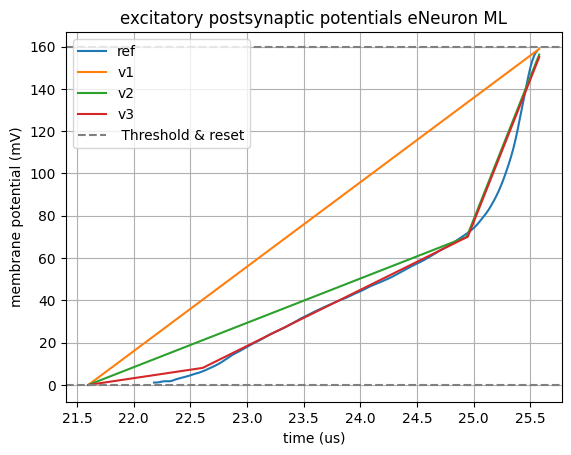

In [6]:
nb=400
data1 = v_spike[2200:2200+nb]
data2 = trace1[0].v[:nb]/mV
data3 = trace2[0].v[:nb]/mV
data4 = trace3[0].v[:nb]/mV

plt.figure()
potent = np.copy(v_spike[2200:2200+nb])
potent += abs(v_reset/mV)
min_pot,max_pot = np.argmin(potent),np.argmax(potent)
potent = potent[min_pot:max_pot]
time_t = np.copy(time[2200:2200+nb])
time_t = time_t[min_pot:max_pot]


timestep = [time_t[i+1] - time_t[i] for i in range(len(time_t)-1)]

integr_ref = sum(potent)*np.mean(timestep)
print(" integr eNeuron ML = ", integr_ref)
plt.plot(time_t,potent,label='ref')



potent = np.copy(trace1[0].v[:nb]/mV)
potent += abs(v_reset/mV)
min_pot,max_pot = np.argmin(potent),np.argmax(potent)
potent = potent[min_pot:max_pot]
time_t = np.copy(trace1.t/us)
time_t = np.copy(time_t[min_pot:max_pot])

timestep = [time_t[i+1] - time_t[i] for i in range(len(time_t)-1)]

integr_1 = sum(potent)*np.mean(timestep)
print(" integr model v1 = ", integr_1)
plt.plot(time_t,potent,label='v1')


potent = np.copy(trace2[0].v[:nb]/mV)
potent += abs(v_reset/mV)
min_pot,max_pot = np.argmin(potent),np.argmax(potent)
potent = potent[min_pot:max_pot]
time_t = np.copy(trace2.t/us)
time_t = np.copy(time_t[min_pot:max_pot])

timestep = [time_t[i+1] - time_t[i] for i in range(len(time_t)-1)]

integr_2 = sum(potent)*np.mean(timestep)
print(" integr model v2 = ", integr_2)
plt.plot(time_t,potent,label='v2')


potent = np.copy(trace3[0].v[:nb]/mV)
potent += abs(v_reset/mV)
min_pot,max_pot = np.argmin(potent),np.argmax(potent)
potent = potent[min_pot:max_pot]
time_t = np.copy(trace3.t/us)
time_t = np.copy(time_t[min_pot:max_pot])

timestep = [time_t[i+1] - time_t[i] for i in range(len(time_t)-1)]

integr_3 = sum(potent)*np.mean(timestep)
print(" integr model v3 = ", integr_3)
plt.plot(time_t,potent,label='v3')

plt.axhline(y=100+v_threshold/mV, color='grey', linestyle='--',label=' Threshold & reset')
plt.axhline(y=0, color='grey', linestyle='--')
plt.xlabel('time (us)')
plt.ylabel('membrane potential (mV)')
plt.title('excitatory postsynaptic potentials eNeuron ML')
plt.grid(True)
plt.legend()
plt.show()




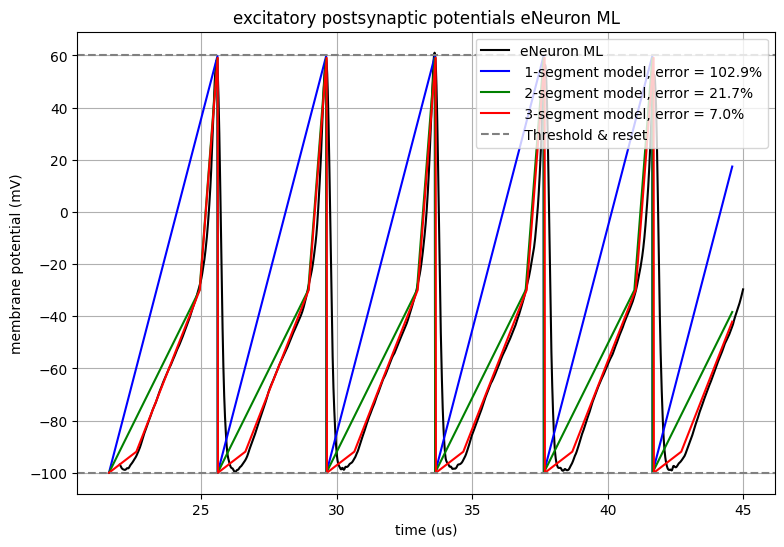

In [7]:

plt.figure(figsize=(9, 6))
plt.plot(time[2200:4500], v_spike[2200:4500],color='black', label='eNeuron ML')
plt.plot(trace1.t/us, trace1[0].v/mV,color='b',label=f' 1-segment model, error = {round(100*abs((integr_1-integr_ref)/integr_ref),1)}%')
plt.plot(trace2.t/us, trace2[0].v/mV,color='g',label=f' 2-segment model, error = {round(100*abs((integr_2-integr_ref)/integr_ref),1)}%')
plt.plot(trace3.t/us, trace3[0].v/mV,color='r',label=f' 3-segment model, error = {round(100*abs((integr_3-integr_ref)/integr_ref),1)}%')


plt.axhline(y=v_threshold/mV, color='grey', linestyle='--',label=' Threshold & reset')
plt.axhline(y=v_reset/mV, color='grey', linestyle='--')
plt.xlabel('time (us)')
plt.ylabel('membrane potential (mV)')
plt.title('excitatory postsynaptic potentials eNeuron ML')
plt.grid(True)
plt.legend()
#plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
#plt.subplots_adjust(right=0.75)


plt.show()

# Modeling eNeuron ML WITH leaky term

Focused on the 3-segment model used in the paper


In [8]:
from brian2 import clear_cache
from brian2 import device
device.reinit()
start_scope()


# Simulation parameters
duration = 0.6*ms #short time for a biological neuron but enough for eNeuron Cadence
defaultclock.dt = 0.0003*us  
#defaultclock.dt = 0.01*us  



neuron_eqs_v1 = '''
dv/dt = (v_rest - v) / tau2 + redress*((y_interp_function(I_total)*I0/(a_value*Hz))*Rm)/ tau : volt (unless refractory)
I_total = clip(Ie + I_inhi + I, 0*nA, 12*nA) : amp
Ie =  alpha_e*ge * uS *(80*mV -c*v)           : amp
I_inhi =  alpha_i*gi * uS *(-120*mV -c*v)           : amp
I : amp
redress = 1+ k_redres*I_total/max_input_current     : 1
dge/dt = -ge/(beta_e*us)            : 1
dgi/dt = -gi/(beta_i*us)            : 1
'''

V_a, V_b= 70*mV,90*mV
R_a = Rm*(V_a/mV)/(5/6)/(abs(v_threshold/mV)+abs(v_reset/mV))  #New resistance for rising till V_a
R_b = Rm*(V_b/mV)/(1/6)/(abs(v_threshold/mV)+abs(v_reset/mV)) #New resistance for rising till V_b
neuron_eqs_v2 = '''
dv/dt = (v_rest - v) / tau2 + redress*((y_interp_function(I_total)*I0/(a_value*Hz))*Rm)/ tau : volt (unless refractory)
I_total = clip(Ie + I_inhi + I, 0*nA, 12*nA) : amp
Ie =  alpha_e*ge * uS *(80*mV -c*v)           : amp
I_inhi =  alpha_i*gi * uS *(-120*mV -c*v)           : amp
I : amp
redress = 1+ k_redres*I_total/max_input_current     : 1
dge/dt = -ge/(beta_e*us)            : 1
dgi/dt = -gi/(beta_i*us)            : 1
Rm = (R_a)*int(v<(v_reset+V_a)) + (R_b)*int(v>=(v_reset+V_a)) : ohm
'''

V_x, V_y, V_z= 8*mV,62*mV,90*mV
R_x = Rm*(V_x/mV)/(15/60)/(abs(v_threshold/mV)+abs(v_reset/mV))  #New resistance for rising till V_a
R_y = Rm*(V_y/mV)/(35/60)/(abs(v_threshold/mV)+abs(v_reset/mV)) #New resistance for rising till V_b
R_z = Rm*(V_z/mV)/(10/60)/(abs(v_threshold/mV)+abs(v_reset/mV)) #New resistance for rising till V_b
neuron_eqs_v3 = '''
dv/dt = (v_rest - v) / tau2 + redress*((y_interp_function(I_total)*I0/(a_value*Hz))*Rm)/ tau : volt (unless refractory)
I_total = clip(Ie + I_inhi + I, 0*nA, 12*nA) : amp
Ie =  alpha_e*ge * uS *(80*mV -c*v)           : amp
I_inhi =  alpha_i*gi * uS *(-120*mV -c*v)           : amp
I : amp
redress = 1+ k_redres*I_total/max_input_current     : 1
dge/dt = -ge/(beta_e*us)            : 1
dgi/dt = -gi/(beta_i*us)            : 1
Rm = (R_x)*int(v<=(v_reset+V_x)) + (R_y)*int(v<=(v_reset+V_x+V_y))*(1-int(v<(v_reset+V_x))) + (R_z)*int(v>(v_reset+V_x+V_y)) : ohm
'''

n = nb_point_interpolation

#input_group_v1 = NeuronGroup(n, neuron_eqs_v1, threshold='v >= v_threshold', reset='v = v_reset', refractory=0*us, method='heun')
#input_group_v1.I = i_new

#input_group_v2 = NeuronGroup(n, neuron_eqs_v2, threshold='v >= v_threshold', reset='v = v_reset', refractory=0*us, method='heun')
#input_group_v2.I = i_new

input_group_v3 = NeuronGroup(n, neuron_eqs_v3, threshold='v >= v_threshold', reset='v = v_reset', refractory=0*us, method='heun')
input_group_v3.I = i_new


# Monitor setup
#monitor1 = SpikeMonitor(input_group_v1)
#monitor2 = SpikeMonitor(input_group_v2)
monitor3 = SpikeMonitor(input_group_v3)

run(duration, report='text', report_period = 600*second)

#firing_rates1 = monitor1.count / duration
#firing_rates2 = monitor2.count / duration
firing_rates3 = monitor3.count / duration


Starting simulation at t=0. s for a duration of 0.6 ms
119.5929 us (19%) simulated in 10m 0s, estimated 40m 10s remaining.
231.2961 us (38%) simulated in 20m 0s, estimated 31m 53s remaining.
0.333435 ms (55%) simulated in 30m 0s, estimated 23m 59s remaining.
0.443121 ms (73%) simulated in 40m 0s, estimated 14m 10s remaining.
0.543822 ms (90%) simulated in 50m 0s, estimated 5m 10s remaining.
0.6 ms (100%) simulated in 55m 11s


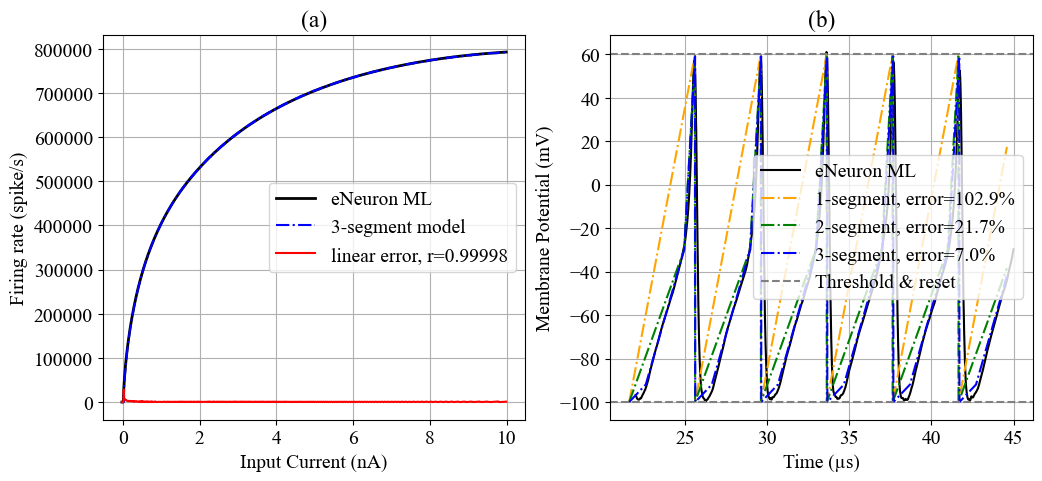

In [9]:

from matplotlib import rcParams

rcParams['font.family'] = 'Times New Roman'
rcParams['font.size'] = 14

plt.figure(figsize=(12, 5))

# Plotting firing rate as a function of input current
plt.subplot(1, 2, 1) 
plt.plot(i_new/nA, f_new/Hz, color='black',linewidth=2, label="eNeuron ML")
# plt.plot(input_group_v1.I/nA, firing_rates1, color='b', label="1-segment model")
# plt.plot(input_group_v2.I/nA, firing_rates2, color='g', label="2-segment model")
plt.plot(input_group_v3.I/nA, firing_rates3, color='b',linestyle='-.', linewidth=1.5, label="3-segment model")
plt.plot(input_group_v3.I/nA, [abs(i-j)**1 for i, j in zip(f_new/Hz, firing_rates3*second)], color='red', label=f"linear error, r={round(np.corrcoef(f_new, firing_rates3)[0, 1], 5)}")
plt.xlabel('Input Current (nA)')
plt.ylabel('Firing rate (spike/s)')
#plt.title('(a)  eNeuron ML and Brian2 neuron model')
plt.title('(a)')
plt.grid(True)
plt.legend(loc='center right')

plt.subplot(1, 2, 2) 
plt.plot(time[2200:4500], v_spike[2200:4500], color='black', label='eNeuron ML')
plt.plot(trace1.t/us, trace1[0].v/mV, color='orange',linestyle='-.', label=f'1-segment, error={round(100*abs((integr_1-integr_ref)/integr_ref), 1)}%')
plt.plot(trace2.t/us, trace2[0].v/mV, color='green',linestyle='-.', label=f'2-segment, error={round(100*abs((integr_2-integr_ref)/integr_ref), 1)}%')
plt.plot(trace3.t/us, trace3[0].v/mV, color='b', linestyle='-.', label=f'3-segment, error={round(100*abs((integr_3-integr_ref)/integr_ref), 1)}%')
plt.axhline(y=v_threshold/mV, color='grey', linestyle='--', label='Threshold & reset')
plt.axhline(y=v_reset/mV, color='grey', linestyle='--')
plt.xlabel('Time (µs)')
plt.ylabel('Membrane Potential (mV)')
#plt.title('(b)  excitatory postsynaptic potentials eNeuron ML')
plt.title('(b)')
plt.grid(True)

#lgd = plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
#lgd = plt.legend()
lgd = plt.legend(loc='center right')

#plt.savefig('results/FT.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
#plt.savefig('results/FT.svg', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()


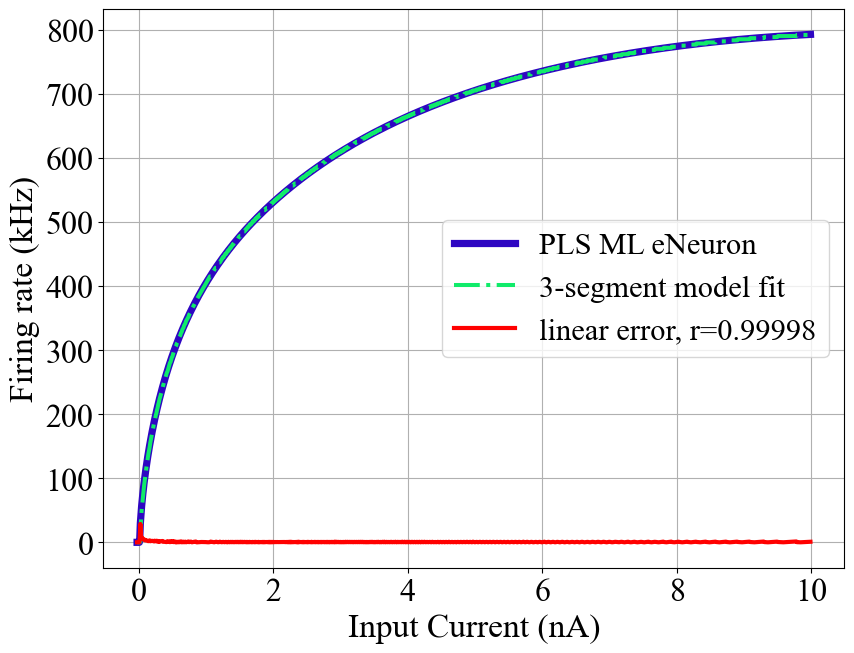

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

# Set global font configurations using matplotlib to ensure that all plots
# use the 'Times New Roman' serif font.
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = ['Times New Roman']



# Create a plot figure with defined figure size
plt.figure(figsize=(9, 7))
# Define a color palette for the plot lines
colors = ['#1f77b4',  # Blue
          '#d62728',  # Red
          '#ff7f0e',  # Orange
          '#2ca02c']  # Green


plt.plot(i_new/nA, f_new/kHz, color='#2E06C2',linewidth=5.2, label="PLS ML eNeuron")
# plt.plot(input_group_v1.I/nA, firing_rates1, color='b', label="1-segment model")
# plt.plot(input_group_v2.I/nA, firing_rates2, color='g', label="2-segment model")
plt.plot(input_group_v3.I/nA, firing_rates3/1000, color='#10EB6A',linestyle='-.', linewidth=2.9, label="3-segment model fit")
plt.plot(input_group_v3.I/nA, [0.001*abs(i-j)**1 for i, j in zip(f_new/Hz, firing_rates3*second)], color='red',linewidth=3, label=f"linear error, r={round(np.corrcoef(f_new, firing_rates3)[0, 1], 5)}")

plt.xlabel('Input Current (nA)',fontsize=24)
plt.ylabel('Firing rate (kHz)',fontsize=24)
#plt.title('(a)  eNeuron ML and Brian2 neuron model')
plt.grid(True)
plt.legend(loc='center right', fontsize=22)

# Set the font size of ticks on the x-axis
plt.xticks(fontsize=23)
plt.yticks(fontsize=23)


# Adjust layout to prevent overlap of plot elements
plt.tight_layout()
# Enable grid for better readability of the plot
plt.grid(True)

# Add a legend to the plot, specify its location and font size
#plt.legend(loc='upper right', fontsize=20)

plt.savefig('results/activation_function.pdf', format='pdf', dpi=300)
plt.show()

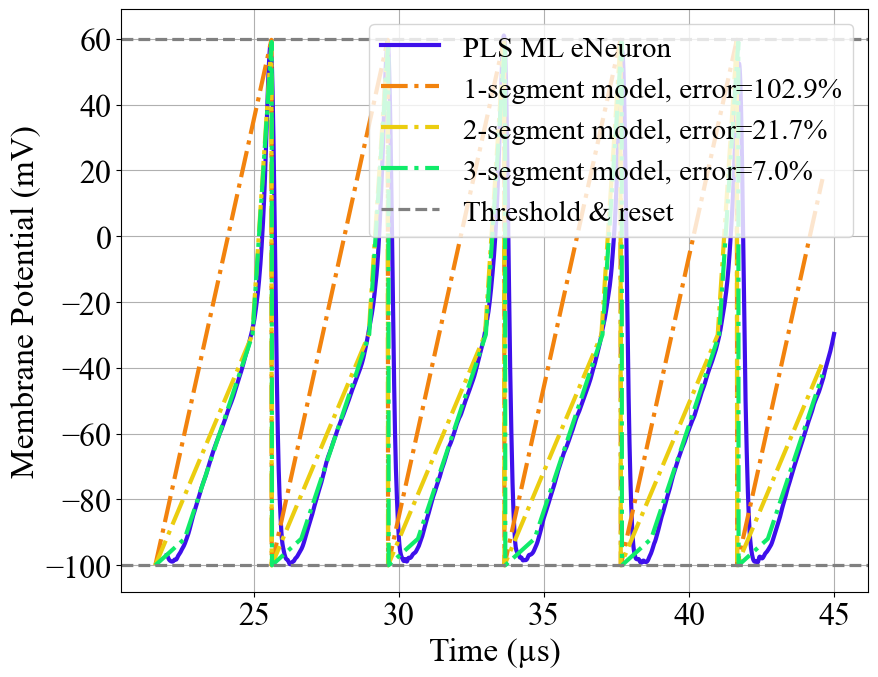

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

# Set global font configurations using matplotlib to ensure that all plots
# use the 'Times New Roman' serif font.
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = ['Times New Roman']



# Create a plot figure with defined figure size
plt.figure(figsize=(9, 7))
# Define a color palette for the plot lines
colors = ['#3E10EB',  # Blue
          '#EBCD10',  # Red
          '#98EB10',  # Orange
          '#10EB6A']  # Green


plt.plot(time[2200:4500], v_spike[2200:4500], color='#3E10EB',linewidth=3, label='PLS ML eNeuron')
plt.plot(trace1.t/us, trace1[0].v/mV, color='#F2830E',linewidth=3,linestyle='-.', label=f'1-segment model, error={round(100*abs((integr_1-integr_ref)/integr_ref), 1)}%')
plt.plot(trace2.t/us, trace2[0].v/mV, color='#EBCD10',linewidth=3,linestyle='-.', label=f'2-segment model, error={round(100*abs((integr_2-integr_ref)/integr_ref), 1)}%')
plt.plot(trace3.t/us, trace3[0].v/mV, color='#10EB6A',linewidth=3, linestyle='-.', label=f'3-segment model, error={round(100*abs((integr_3-integr_ref)/integr_ref), 1)}%')
plt.axhline(y=v_threshold/mV, color='grey', linestyle='--',linewidth=2.3, label='Threshold & reset')
plt.axhline(y=v_reset/mV, color='grey',linewidth=2.3, linestyle='--')
plt.xlabel('Time (µs)',fontsize=24)
plt.ylabel('Membrane Potential (mV)',fontsize=24)
#plt.title('(b)  excitatory postsynaptic potentials eNeuron ML')
plt.grid(True)

# Set the font size of ticks on the x-axis
plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

# Adjust layout to prevent overlap of plot elements
plt.tight_layout()
# Enable grid for better readability of the plot
plt.grid(True)


# Add a legend to the plot, specify its location and font size
plt.legend(loc='best', fontsize=21)

# Save the plot to a PDF file with high resolution
plt.savefig('results/Potential_membrane.pdf', format='pdf', dpi=300)
# Display the plot as output
plt.show()

### Zoom on the very left part

max Firing rate eNeuron ML = 792559.6043922332 max Firing rate model (v3)= 791666.6666666667 

k_redres =  0.0011279213375576802


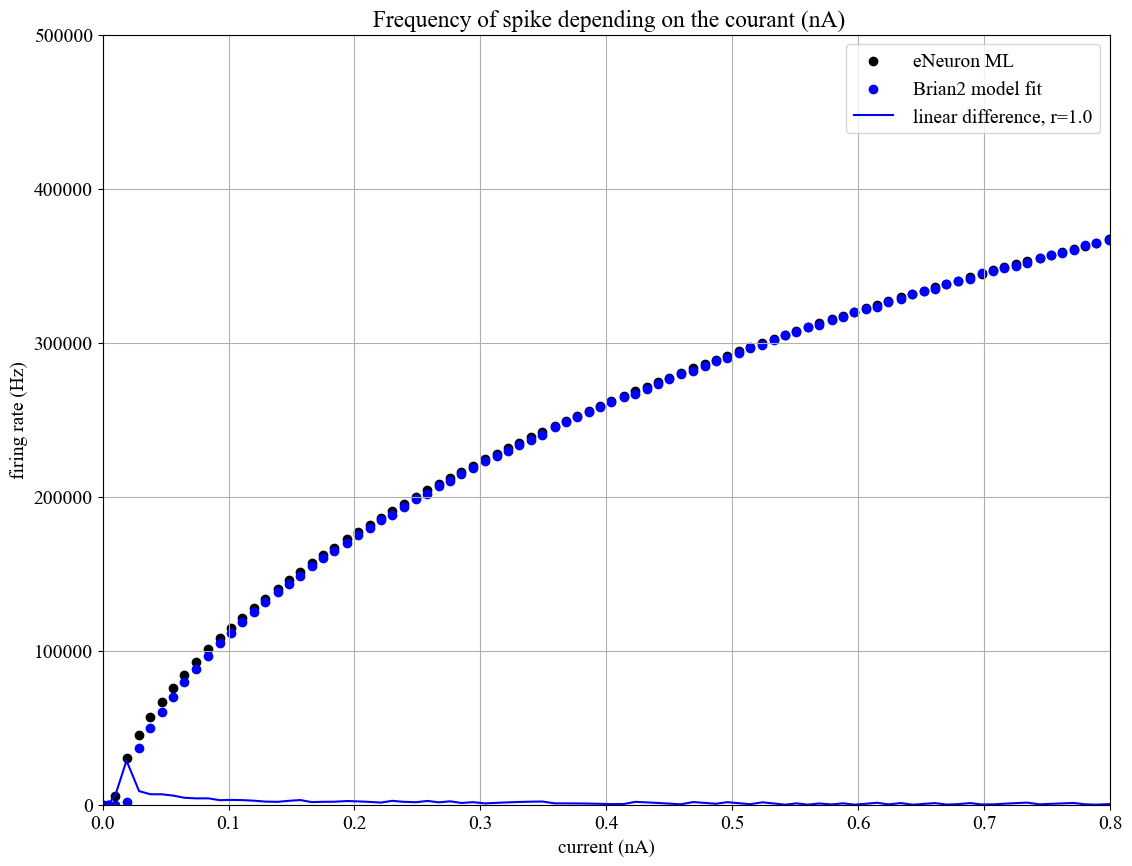

In [12]:
print("max Firing rate eNeuron ML =", f_new[-1]/Hz, "max Firing rate model (v3)=",firing_rates3[-1]*second,"\n")
k_redres =  (f_new[-1]/Hz)/(firing_rates3[-1]*second) - 1
print("k_redres = ",k_redres)

plt.figure(figsize=(13, 10))

plt.scatter(i_new/nA,f_new/Hz,color='black',label=" eNeuron ML")
plt.scatter(input_group_v3.I/nA, firing_rates3,color='b',label=" Brian2 model fit")
plt.plot(input_group_v3.I/nA,[abs(i-j) for i,j in zip(f_new/Hz,firing_rates3*second)],color='b',label=f" linear difference, r={round(np.corrcoef(f_new, firing_rates3)[0, 1],4)}")

plt.xlabel('current (nA)')
plt.ylabel('firing rate (Hz)')
plt.title(' Frequency of spike depending on the courant (nA)')
plt.grid(True)
plt.legend()
plt.xlim([-5e-12,0.8])  
plt.ylim([-1, 500000])

plt.show()